In [1]:
import pandas
import datetime
import urllib
import bs4
import os
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import ticker
import seaborn as sns
import scipy
import feather
%matplotlib inline

In [2]:
rel_perc_cutoff = 0.15

In [3]:
finBndDF = feather.read_dataframe('../data/trghBndDst-fits.feather')
# There is 24 MLT and 0 MLT, remove the discrepancy
finBndDF["mlt"] = finBndDF["mlt"]%24
finBndDF = finBndDF.drop_duplicates()
finBndDF["dst_bin"] = finBndDF["dst_bin"].astype(str)

In [4]:
# Discard MLTs(for each dst_bin) where num observations are low
cntNMltDstPnts = finBndDF.groupby(["dst_bin", "normMLT"]).size().reset_index()
cntNMltDstPnts.columns = ["dst_bin", "normMLT", "cnt"]

cntMaxPnts = cntNMltDstPnts[ ["dst_bin", "cnt"] ].groupby("dst_bin").max().reset_index()
cntMaxPnts.columns = ["dst_bin", "max_cnt"]

cntNMltDstPnts = pandas.merge( cntNMltDstPnts, cntMaxPnts, on=["dst_bin"] )
cntNMltDstPnts["rel_perc"] = cntNMltDstPnts["cnt"]/cntNMltDstPnts["max_cnt"]
cntNMltDstPnts = cntNMltDstPnts[ cntNMltDstPnts["rel_perc"] > rel_perc_cutoff ].reset_index(drop=True)
cntNMltDstPnts = cntNMltDstPnts[ [ "dst_bin", "normMLT", "rel_perc" ] ]
cntNMltDstPnts.head()

,dst_bin,normMLT,rel_perc
0,"(-10, 10]",-3.0,0.168704
1,"(-10, 10]",-2.0,0.353223
2,"(-10, 10]",-1.0,0.601528
3,"(-10, 10]",0.0,0.818738
4,"(-10, 10]",1.0,0.960532


In [5]:
# discard trghMean locations where obse are low
finBndDF = pandas.merge( finBndDF, cntNMltDstPnts, on=["dst_bin", "normMLT"], how="inner" )

In [6]:
trghMeanDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).mean().reset_index()
trghMeanDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_mean', 'tecEqu_mean', 'mlon_mean',
       'mlatPol_mean', 'tecPol_mean', 'mlatMin_mean', 'tecMin_mean', 'mlonAdjst_mean',
       'delTecEqu_mean', 'delTecPol_mean', 'delMlat_mean', 'timeStr_mean', 'dst_index_mean', 'rel_perc_mean']
trghStdDF = finBndDF.groupby( ["dst_bin", "normMLT", "mlt"] ).std().reset_index()
trghStdDF.columns = ['dst_bin', 'normMLT', 'mlt', 'mlatEqu_std', 'tecEqu_std', 'mlon_std',
       'mlatPol_std', 'tecPol_std', 'mlatMin_std', 'tecMin_std', 'mlonAdjst_std',
       'delTecEqu_std', 'delTecPol_std', 'delMlat_std', 'timeStr_std', 'dst_index_std', 'rel_perc_std']
trghMeanDF = pandas.merge( trghMeanDF, trghStdDF, on=["dst_bin", "normMLT", "mlt"] )
trghMeanDF = trghMeanDF.dropna().reset_index(drop=True)
trghMeanDF.head()

,dst_bin,normMLT,mlt,mlatEqu_mean,tecEqu_mean,mlon_mean,mlatPol_mean,tecPol_mean,mlatMin_mean,tecMin_mean,...,tecPol_std,mlatMin_std,tecMin_std,mlonAdjst_std,delTecEqu_std,delTecPol_std,delMlat_std,timeStr_std,dst_index_std,rel_perc_std
0,"(-10, 10]",-3.0,21.0,53.054113,60.292703,66.940324,286.672706,-70.491532,5.767901,3.676802,...,24.636639,2.514069,1.988274,2.378100,164.622063,1.278013,1.195792,3.673999,4.945651,0.0
1,"(-10, 10]",-2.0,22.0,52.136483,59.654314,66.592898,290.170805,-65.224229,5.883296,3.867457,...,25.477006,2.341813,2.055292,2.393627,171.807591,1.209754,1.229347,3.279394,4.919972,0.0
2,"(-10, 10]",-1.0,23.0,51.473615,59.096285,66.233173,294.368718,-58.672263,5.723219,3.700376,...,26.703592,2.152714,1.952053,2.252076,181.237999,1.145823,1.209036,2.807351,5.066290,0.0
3,"(-10, 10]",0.0,0.0,50.996096,58.784787,66.098343,297.961532,-50.176757,5.537713,3.356817,...,26.175764,2.060432,1.756130,2.155382,177.784436,1.219754,1.269629,2.418479,5.026143,0.0
4,"(-10, 10]",1.0,1.0,50.754772,58.641968,66.022368,298.494051,-41.359297,5.466132,3.131758,...,25.429303,2.008888,1.609357,2.039238,172.384114,1.257380,1.259982,2.130538,5.075928,0.0


In [7]:
def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)

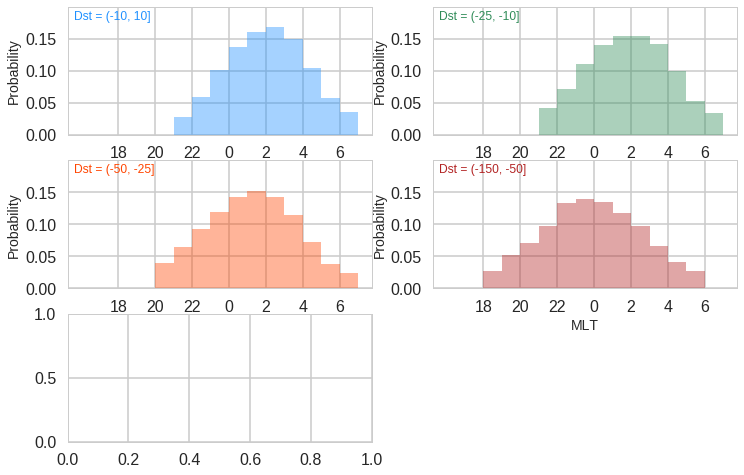

In [8]:
bins = range(-8,8,1)
colDict = {}
colDict['(-10, 10]'] = 'dodgerblue'
colDict['(-25, -10]'] = 'seagreen'
colDict['(-50, -25]'] = 'orangered'
colDict['(-150, -50]'] = 'firebrick'

sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) )
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )

dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']
for binInd, currDstBin in enumerate(dstBinArrSorted):
    selDF = finBndDF[ finBndDF["dst_bin"] == currDstBin]
#     sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
#                  hist=True, fit=scipy.stats.gennorm,\
#                  fit_kws={"color": colDict[currDstBin]},\
#                  hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
    sns.distplot(selDF["normMLT"].values, bins=bins, kde=False,\
                 hist=True,norm_hist=True,\
                 fit_kws={"color": colDict[currDstBin]},\
                 hist_kws={"color": colDict[currDstBin]}, ax=axArr[binInd])
#     break
    axArr[binInd].set_xlabel("MLT", fontsize=14)
    axArr[binInd].set_ylabel("Probability", fontsize=14)
    axArr[binInd].set_xticks( range(-6,7,2) )
    axArr[binInd].set_ylim([0,0.2])
    axArr[binInd].set_yticks( numpy.arange(0,0.2,0.05) )
    axArr[binInd].xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks)) 
    axArr[binInd].text(0.02, 0.9,  "Dst = " + currDstBin,
            transform=axArr[binInd].transAxes,
            color=colDict[currDstBin], fontsize=12)
plt.savefig("../figs/allBinsHist.pdf",bbox_inches='tight')

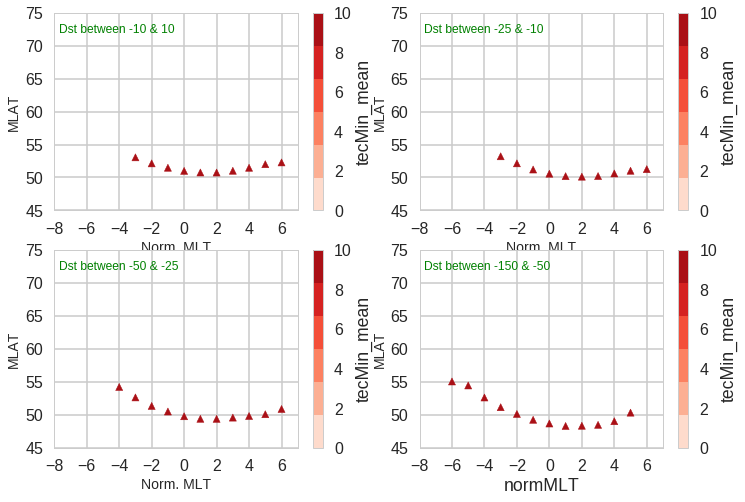

In [9]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax4 = f.add_subplot(2,2,1)
ax3 = f.add_subplot(2,2,2)
ax2 = f.add_subplot(2,2,3)
ax1 = f.add_subplot(2,2,4)


vmin=0.
vmax=10.
xlim = [-8, 7]
ylim = [ 45, 75 ]
xticksList = range(xlim[0],xlim[1]+1, 2)

seaMap = ListedColormap(sns.color_palette("Reds"))

# (-150,-75]
trghSel15075 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-150, -50]" ]
trghSel15075.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1)
trghSel15075.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
trghSel15075.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax1,colorbar=False)
ax1.set_ylabel("MLAT", fontsize=14)
# ax1.set_xlabel("Norm. MLT", fontsize=14)
# ax1.set_title( "Dst between -150 & -75", fontsize=14 )
ax1.text(0.02, 0.9,  "Dst between -150 & -50",
            transform=ax1.transAxes,
            color="green", fontsize=12)
ax1.set_xlim( xlim )
ax1.set_ylim( ylim )
ax1.set_xticks(xticksList)


# (-50, -25]
trghSel5025 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-50, -25]" ]
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
trghSel5025.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax2,colorbar=False)
ax2.set_ylabel("MLAT", fontsize=14)
ax2.set_xlabel("Norm. MLT", fontsize=14)
# ax2.set_title( "Dst between -50 & -25", fontsize=14 )
ax2.text(0.02, 0.9,  "Dst between -50 & -25",
            transform=ax2.transAxes,
            color="green", fontsize=12)
ax2.set_xlim( xlim )
ax2.set_ylim( ylim )
ax2.set_xticks(xticksList)
# (-25, -10]
trghSel2510 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-25, -10]" ]
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
trghSel2510.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax3,colorbar=False)
ax3.set_ylabel("MLAT", fontsize=14)
ax3.set_xlabel("Norm. MLT", fontsize=14)
# ax3.set_title( "Dst between -25 & -10", fontsize=14 )
ax3.text(0.02, 0.9,  "Dst between -25 & -10",
            transform=ax3.transAxes,
            color="green", fontsize=12)
ax3.set_xlim( xlim )
ax3.set_ylim( ylim )
ax3.set_xticks(xticksList)
# (-10, 10]
trghSel1010 = trghMeanDF[ trghMeanDF["dst_bin"] == "(-10, 10]" ]
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatMin_mean',
              c='tecMin_mean',
              s=50, cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatEqu_mean',
              c='tecEqu_mean',
              s=50, marker='^', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
trghSel1010.plot( kind='scatter',
              x='normMLT',
              y='mlatPol_mean',
              c='tecPol_mean',
              s=50, marker='v', cmap=seaMap, vmin=vmin, vmax=vmax, ax=ax4,colorbar=False)
ax4.set_ylabel("MLAT", fontsize=14)
ax4.set_xlabel("Norm. MLT", fontsize=14)
# ax4.set_title( "Dst between -10 & 10", fontsize=14 )
ax4.text(0.02, 0.9,  "Dst between -10 & 10",
            transform=ax4.transAxes,
            color="green", fontsize=12)
ax4.set_xlim( xlim )
ax4.set_ylim( ylim )
ax4.set_xticks(xticksList)
plt.savefig("../figs/allBinsTrghLoc.pdf",bbox_inches='tight')

<Container object of 3 artists>

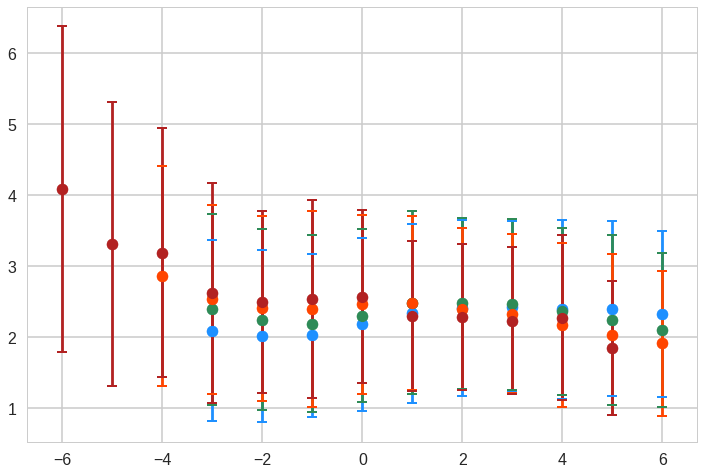

In [10]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color=colDict["(-10, 10]"],
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=trghMeanDF['delTecPol_std'][trghMeanDF['dst_bin'] == "(-10, 10]"], \
             color=colDict["(-10, 10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color=colDict["(-25, -10]"],
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=trghMeanDF['delTecPol_std'][trghMeanDF['dst_bin'] == "(-25, -10]"], \
             color=colDict["(-25, -10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color=colDict["(-50, -25]"],
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=trghMeanDF['delTecPol_std'][trghMeanDF['dst_bin'] == "(-50, -25]"], \
             color=colDict["(-50, -25]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            marker='o',
            color=colDict["(-150, -50]"],
            alpha=0.7,
            s = 124,
            label='(-150, -50]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             trghMeanDF['delTecPol_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             yerr=trghMeanDF['delTecPol_std'][trghMeanDF['dst_bin'] == "(-150, -50]"], \
             color=colDict["(-150, -50]"], label='', capthick=2., capsize=5., fmt='o')



<Container object of 3 artists>

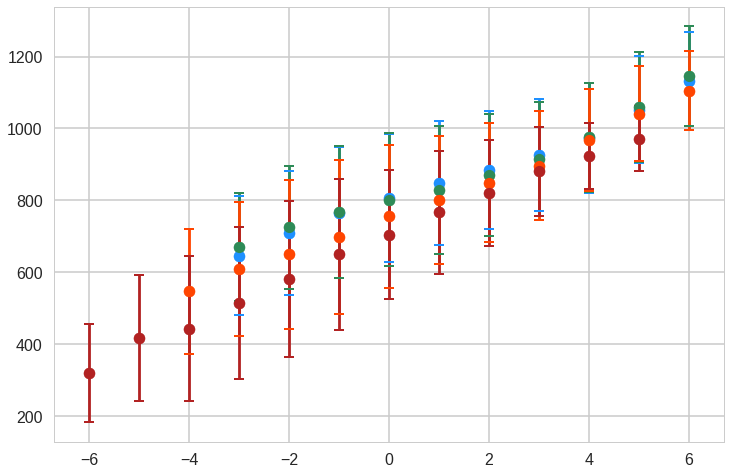

In [11]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color=colDict["(-10, 10]"],
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=trghMeanDF['delTecEqu_std'][trghMeanDF['dst_bin'] == "(-10, 10]"], \
             color=colDict["(-10, 10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color=colDict["(-25, -10]"],
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=trghMeanDF['delTecEqu_std'][trghMeanDF['dst_bin'] == "(-25, -10]"], \
             color=colDict["(-25, -10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color=colDict["(-50, -25]"],
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=trghMeanDF['delTecEqu_std'][trghMeanDF['dst_bin'] == "(-50, -25]"], \
             color=colDict["(-50, -25]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            marker='o',
            color=colDict["(-150, -50]"],
            alpha=0.7,
            s = 124,
            label='(-150, -50]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             trghMeanDF['delTecEqu_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             yerr=trghMeanDF['delTecEqu_std'][trghMeanDF['dst_bin'] == "(-150, -50]"], \
             color=colDict["(-150, -50]"], label='', capthick=2., capsize=5., fmt='o')



<Container object of 3 artists>

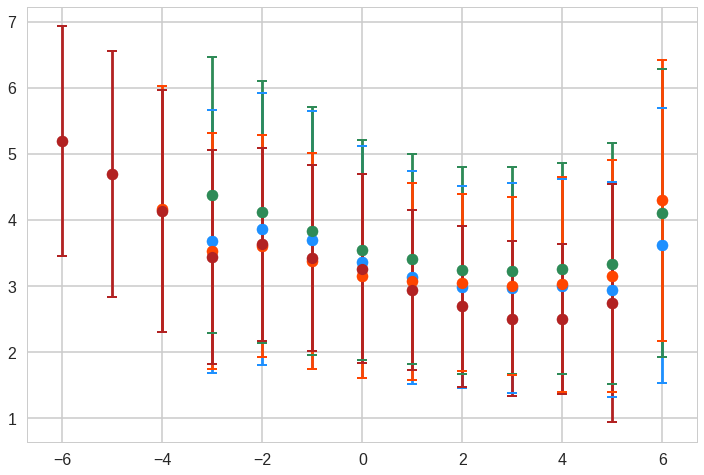

In [12]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color=colDict["(-10, 10]"],
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=trghMeanDF['tecMin_std'][trghMeanDF['dst_bin'] == "(-10, 10]"], \
             color=colDict["(-10, 10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color=colDict["(-25, -10]"],
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=trghMeanDF['tecMin_std'][trghMeanDF['dst_bin'] == "(-25, -10]"], \
             color=colDict["(-25, -10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color=colDict["(-50, -25]"],
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=trghMeanDF['tecMin_std'][trghMeanDF['dst_bin'] == "(-50, -25]"], \
             color=colDict["(-50, -25]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            marker='o',
            color=colDict["(-150, -50]"],
            alpha=0.7,
            s = 124,
            label='(-150, -50]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             trghMeanDF['tecMin_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             yerr=trghMeanDF['tecMin_std'][trghMeanDF['dst_bin'] == "(-150, -50]"], \
             color=colDict["(-150, -50]"], label='', capthick=2., capsize=5., fmt='o')


<Container object of 3 artists>

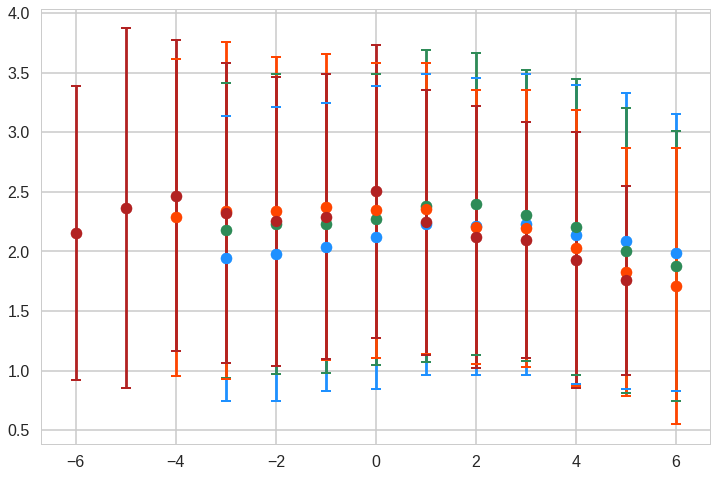

In [13]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
sns.set_style("whitegrid")
sns.set_context("poster")

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],
            marker='o',
            color=colDict["(-10, 10]"],
            alpha=0.7,
            s = 124,
            label='(-10, 10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-10, 10]"],\
             yerr=trghMeanDF['delMlat_std'][trghMeanDF['dst_bin'] == "(-10, 10]"], \
             color=colDict["(-10, 10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],
            marker='o',
            color=colDict["(-25, -10]"],
            alpha=0.7,
            s = 124,
            label='(-25, -10]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-25, -10]"],\
             yerr=trghMeanDF['delMlat_std'][trghMeanDF['dst_bin'] == "(-25, -10]"], \
             color=colDict["(-25, -10]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],
            marker='o',
            color=colDict["(-50, -25]"],
            alpha=0.7,
            s = 124,
            label='(-50, -25]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-50, -25]"],\
             yerr=trghMeanDF['delMlat_std'][trghMeanDF['dst_bin'] == "(-50, -25]"], \
             color=colDict["(-50, -25]"], label='', capthick=2., capsize=5., fmt='o')

ax1.scatter(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],
            marker='o',
            color=colDict["(-150, -50]"],
            alpha=0.7,
            s = 124,
            label='(-150, -50]')
ax1.errorbar(trghMeanDF['normMLT'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             trghMeanDF['delMlat_mean'][trghMeanDF['dst_bin'] == "(-150, -50]"],\
             yerr=trghMeanDF['delMlat_std'][trghMeanDF['dst_bin'] == "(-150, -50]"], \
             color=colDict["(-150, -50]"], label='', capthick=2., capsize=5., fmt='o')


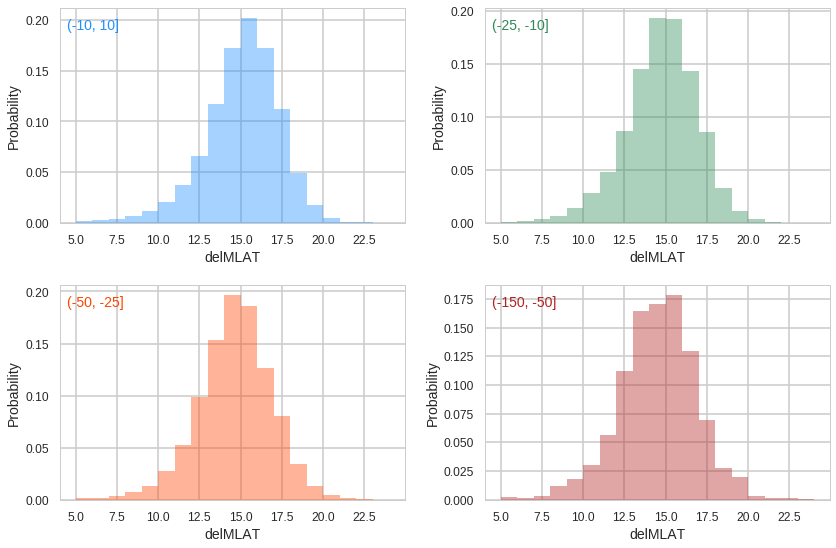

In [14]:
dstBinArrSorted = ['(-10, 10]', '(-25, -10]', '(-50, -25]', '(-150, -50]']


bins = numpy.arange(5,25,1)

f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(2,2,1) )
axArr.append( f.add_subplot(2,2,2) )
axArr.append( f.add_subplot(2,2,3) )
axArr.append( f.add_subplot(2,2,4) )

for ssnInd, currSsn in enumerate(dstBinArrSorted):
    selDF = finBndDF[ finBndDF["dst_bin"] == currSsn ]
    sns.distplot( selDF["delMlat"].values, bins=bins, kde=False,\
                     hist=True,norm_hist=True,\
                     hist_kws={"color": colDict[currSsn]},\
                     ax=axArr[ssnInd] )
    axArr[ssnInd].text(0.02, 0.9,  currSsn.upper(),
            transform=axArr[ssnInd].transAxes,
            color=colDict[currSsn], fontsize=14)
    axArr[ssnInd].set_ylabel("Probability", fontsize=14)
    axArr[ssnInd].set_xlabel("delMLAT", fontsize=14)
    axArr[ssnInd].tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("../figs/delMLAT-GMAG.eps",bbox_inches='tight')